# Mechanical Turk Experiments

In [18]:
import torch
from torchvision import datasets, transforms, utils
from torchvision.transforms.functional import to_pil_image
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from PIL import Image

import random

%matplotlib inline

#My helpers
import helpers

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# My stuff
from gradcam.gradcam import GradCAM
from gradcam.utils import create_occlusion
from experiments.utils import deterministic_testloader, upload_to_s3, create_img_list

In [19]:
# Import models
device = helpers.set_device()
non_pruned = helpers.load_model('trained_imgnette_models/run8_pretrained_100ep_ft_no_normalization.pt', device)
lmu_2 = helpers.load_model('pruned_models/local_magnitude_unstructured-pretrained/2-compression_02-05-2021_09-18-46.pt', device)
lmu_32 = helpers.load_model('pruned_models/local_magnitude_unstructured-pretrained/32-compression_02-05-2021_13-28-20.pt', device)

--- stays on cpu - no cuda device available---


In [20]:
# Imagenette Classes
classes = ['0-fish', 
           '1-dog', 
           '2-cassetteplayer', 
           '3-chainsaw',
           '4-church', 
           '5-frenchhorn', 
           '6-garbagetruck', 
           '7-gaspump', 
           '8-golfball', 
           '9-parachute']

classes_show = ['Fish', 
           'Dog', 
           'Cassette Player', 
           'Chainsaw',
           'Church', 
           'Frenchhorn', 
           'Garbage Truck', 
           'Gaspump', 
           'Golfball', 
           'Parachute']

In [21]:
# CREATE MY BLACK-TRANSPARENT COLOR MAP
cmap = pl.cm.gray
my_cmap = cmap(np.arange(cmap.N))
# Transform alpha values as cmap shape RGBA
my_cmap[:,-1] = np.linspace(1.0, 0.0, cmap.N)
my_cmap = ListedColormap(my_cmap)

## EXPERIMENTS

#### Requirements
- D 50 images of every class, predicted correctly by every classifier
- 10% occlusion maps
- Experiment 1
    - 3 Images in a row: 2/32, original, non-pruned
    - 2/32 and non-pruned switch sides randomly
    - 500 Bilder - 2 Varianten - 5mal = 5000 Tasks
    - Bildbenennung: 01_nonpruned_2-dog_32pruned
- Experiment 2
    - gleiche Bilder wie im Experiment 1
    - immer nur 1 Bild zeigen
    - 10 Klassen + 'I don't know / none of the above' hinzufügen
    - 500 Bilder - 3 Varianten - 5mal = 7500 Tasks
    - Bildbenennung: 01_3-chainsaw_nonpruned

In [5]:
batch_size = 50
_, vizloader = deterministic_testloader(batch_size, shuffle = True)

In [9]:
# Models we want to check
models_dict = {
    'nonpruned': non_pruned,
    '2pruned': lmu_2,
    '32pruned': lmu_32,
}

In [7]:
def prediction_checker(models_dict, image, label):
    passed = True
    for _, model in models_dict.items():
        pred = model(image.unsqueeze(0))
        if label != pred.squeeze(0).argmax():
            passed = False
            break
    return passed

In [10]:
# Draw 50 images of every class out of the vizloader
images_per_class = 50

imagelist = []
labellist = []
lbls = {}

for images, labels in vizloader:
    if len(imagelist) == images_per_class * 10:
            break
    for image, label in zip(images, labels):
        labelitem = label.item()
        # check if predicted correctly by every algorithm´
        passed = prediction_checker(models_dict, image, label)
        if passed:
            if labelitem in lbls:
                if lbls[labelitem] < images_per_class:
                    lbls[labelitem] += 1
                    imagelist.append(image)
                    labellist.append(label)
                    if len(imagelist) == images_per_class * 10:
                        break
            else:
                lbls[labelitem] = 1
                # check if predicted correctly by every algorithm´
                passed = prediction_checker(models_dict, image, label)
                if passed:
                    imagelist.append(image)
                    labellist.append(label)
        

print('Label Dictionary:', lbls)
print(len(imagelist), len(labellist))

Label Dictionary: {1: 50, 2: 50, 7: 50, 6: 50, 8: 50, 5: 50, 4: 50, 9: 50, 0: 50, 3: 50}
500 500


### Save Images

In [12]:
# Takes way less storage in comparison to .pkl
torch.save(imagelist, 'experiments/data/imagelist.pt')
torch.save(labellist, 'experiments/data/labellist.pt')

### Load Images

In [22]:
images = torch.load('experiments/data/imagelist.pt')
labels = torch.load('experiments/data/labellist.pt')

Label:  Dog


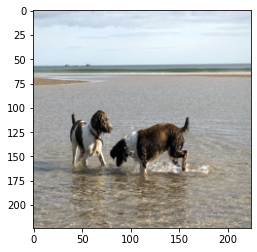

Label:  Cassette Player


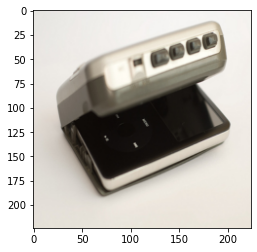

Label:  Gaspump


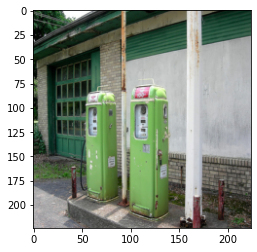

Label:  Garbage Truck


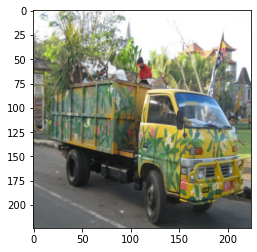

Label:  Gaspump


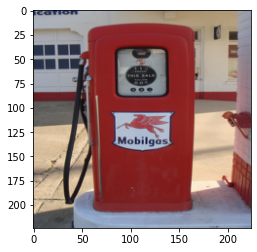

Label:  Gaspump


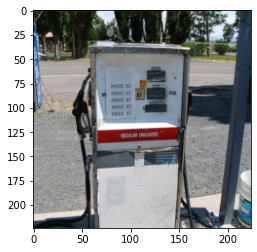

In [55]:
# Test if correct labels and images are saved
for i, (image, label) in enumerate(zip(images, labels)):
    pil_img = to_pil_image(image)
    print('Label: ', classes_show[label.item()])
    plt.imshow(pil_img)
    plt.show()
    if i == 5:
        break

## Experiment 1
Which model is more reasonable?

In [24]:
def shuffle_models(model_list):
    #in-place
    random.shuffle(model_list)
    return model_list

torch.Size([7, 7])
torch.Size([7, 7])
1_2pruned_1-dog_32pruned
torch.Size([7, 7])
torch.Size([7, 7])
2_2pruned_2-cassetteplayer_32pruned


KeyboardInterrupt: 

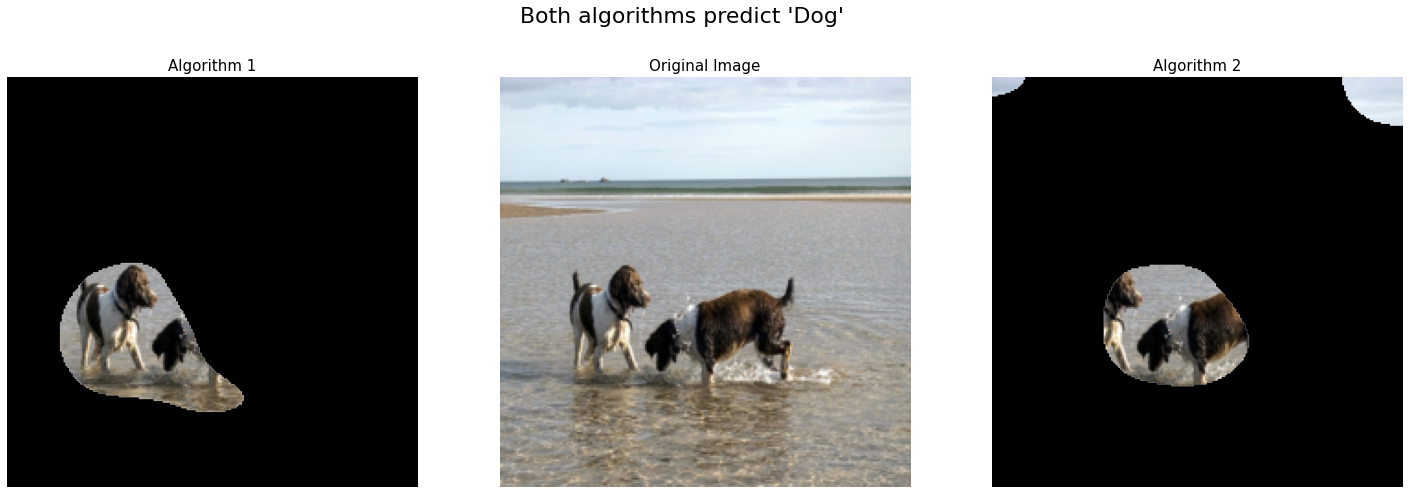

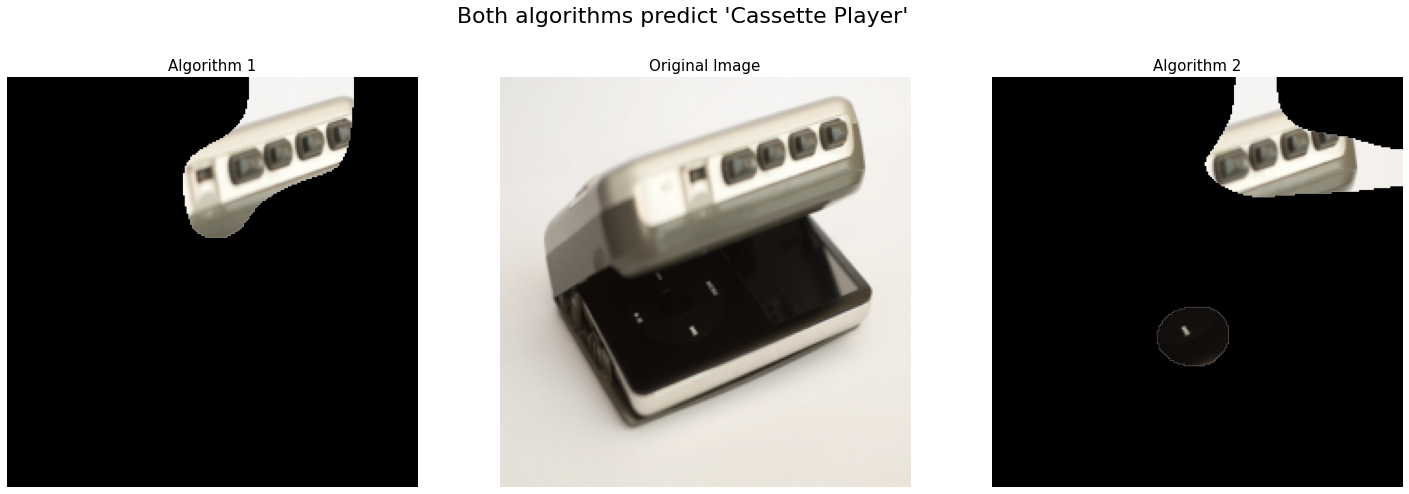

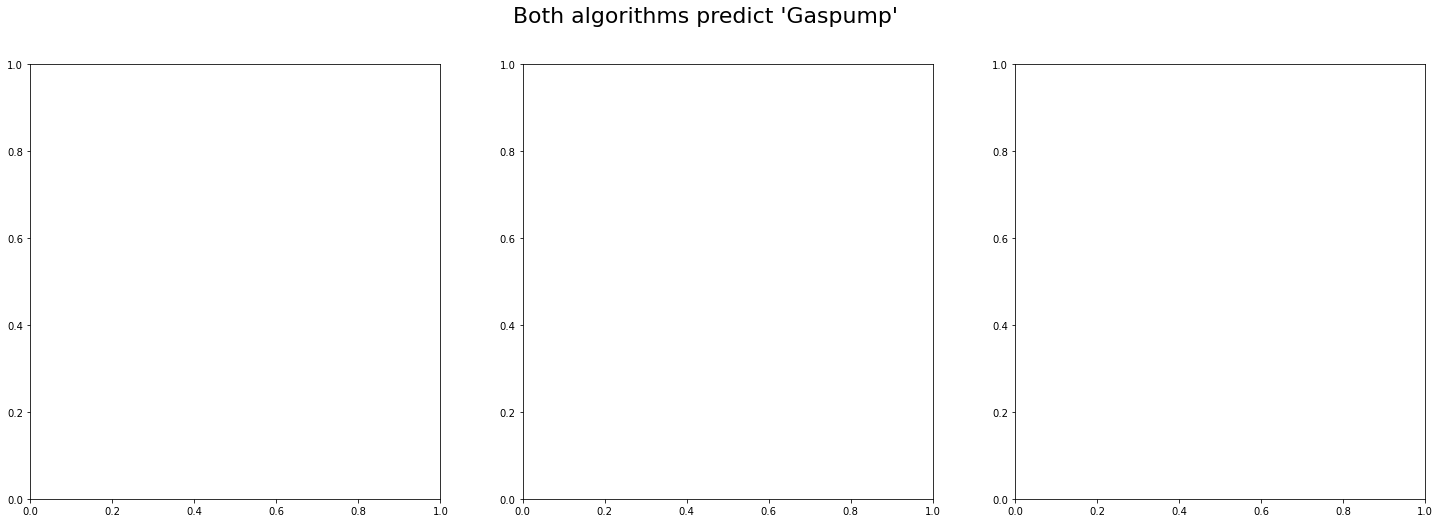

In [56]:
#EXPERIMENT 1

round1 = [('2pruned', lmu_2), ('32pruned', lmu_32)]
#round2 = [('nonpruned', non_pruned), ('32pruned', lmu_32)]
rounds = [round1]

for i, (image, label) in enumerate(zip(images, labels)):
    pil_img = to_pil_image(image)

    for rnd in rounds:
        fig, axes = plt.subplots(ncols=3, figsize=(25, 8))
        fig.suptitle('Both algorithms predict \'{}\''.format(classes_show[label]), size=22)
        rnd = shuffle_models(rnd)
        for j, (name, model) in enumerate(rnd):
            # create GradCAM object
            cam = GradCAM(model)
            # get prediction
            pred = model(image.unsqueeze(0))
            # get activation map
            act_map = cam(pred.squeeze(0).argmax().item(), pred)
            # upsample activation map
            pil_act = to_pil_image(act_map, mode='F')
            pil_act = pil_act.resize(pil_img.size, resample=Image.BICUBIC)
            act_map = np.array(pil_act).astype(float)
            # create occlusion
            occ_map = create_occlusion(act_map, 0.1)
            if j == 0:
                axes[0].set_title('Algorithm 1', size=15)
                axes[0].imshow(pil_img)
                axes[0].imshow(occ_map, cmap=my_cmap)
                axes[0].axis('off')
            if j == 1:
                axes[2].set_title('Algorithm 2', size=15)
                axes[2].imshow(pil_img)
                axes[2].imshow(occ_map, cmap=my_cmap)
                axes[2].axis('off')
        
        axes[1].set_title('Original Image', size=15)
        axes[1].imshow(pil_img)
        axes[1].axis('off')

        img_name = '{}_{}_{}_{}'.format(i+1, rnd[0][0], classes[label], rnd[1][0])
        print(img_name)
        # plt.savefig('experiments/experiment1-sanity/' + img_name + '.png', dpi=150, transparent=True)

In [46]:
# Upload experiment 1 to S3
success = upload_to_s3('experiments/experiment1-sanity/', 'mturk-experiment1-sanity')
print(success)

True


In [47]:
# Create .csv list of images and shuffle them
img_list = create_img_list('experiments/experiment1-sanity/')
len(img_list)

500

## Experiment 2
What do you see on the picture?

KeyboardInterrupt: 

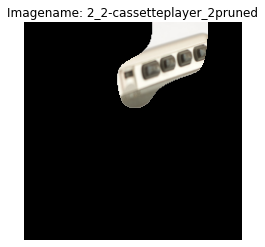

In [21]:
#EXPERIMENT 2

model_list = [('nonpruned', non_pruned), ('2pruned', lmu_2), ('32pruned', lmu_32)]

for i, (image, label) in enumerate(zip(images, labels)):
    pil_img = to_pil_image(image)
    for j, (name, model) in enumerate(model_list):
        # create GradCAM object
        cam = GradCAM(model)
        # get prediction
        pred = model(image.unsqueeze(0))
        # get activation map
        act_map = cam(pred.squeeze(0).argmax().item(), pred)
        # upsample activation map
        pil_act = to_pil_image(act_map, mode='F')
        pil_act = pil_act.resize(pil_img.size, resample=Image.BICUBIC)
        act_map = np.array(pil_act).astype(float)
        # create occlusion
        occ_map = create_occlusion(act_map, 0.1)
        
        # creat plot
        img_name = '{}_{}_{}'.format(i+1, classes[label], name)
        #plt.title('Imagename: ' + img_name)
        plt.imshow(pil_img)
        plt.imshow(occ_map, cmap=my_cmap)
        plt.axis('off')
        # plt.show()
        plt.savefig('experiments/experiment2/' + img_name + '.png', dpi=150, transparent=True)

In [3]:
# Upload experiment 2 to S3
success = upload_to_s3('experiments/experiment2/', 'mturk-experiment2')
print(success)

True


In [2]:
# Create .csv list of images and shuffle them
img_list = create_img_list('experiments/experiment2/')
len(img_list)

1500

## Sources
- Blog - Image Labeling for MechTurk: https://blog.mturk.com/tutorial-how-to-label-thousands-of-images-using-the-crowd-bea164ccbefc
- HTML Elements MechTurk: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-ui-template-reference.html
- Requester Sandbox MechTurk: https://requestersandbox.mturk.com
- Workers Sandbox MechTurk: https://workersandbox.mturk.com
- S3 Upload Example: https://medium.com/bilesanmiahmad/how-to-upload-a-file-to-amazon-s3-in-python-68757a1867c6